In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION AND MODEL DEFINITIONS ---
st.set_page_config(layout="wide", page_title="Crypto Prediction Engine")

ASSET_CONFIG = {
    "Bitcoin (BTC)": {
        "model_path": "bitcoin_hybrid_pytorch_model.pth", "npz_path": "bitcoin_hybrid_pytorch_data.npz", "raw_data_path": "output_10_rows.csv",
        "time_col": "Timestamp", "timeframe_type": "minute", "horizons": {
            "5 Minutes": {"h": 5, "t": "Target_5m_Pct_Change"}, "30 Minutes": {"h": 30, "t": "Target_30m_Pct_Change"},
            "4 Hours": {"h": 240, "t": "Target_4h_Pct_Change"}, "24 Hours": {"h": 1440, "t": "Target_24h_Pct_Change"},}},
    "Ethereum (ETH)": {
        "model_path": "ethereum_hybrid_pytorch_model.pth", "npz_path": "ethereum_hybrid_pytorch_data.npz", "raw_data_path": "ETH_1min.csv",
        "time_col": "Unix Timestamp", "timeframe_type": "minute", "horizons": {
            "5 Minutes": {"h": 5, "t": "Target_5m_Pct_Change"}, "30 Minutes": {"h": 30, "t": "Target_30m_Pct_Change"},
            "4 Hours": {"h": 240, "t": "Target_4h_Pct_Change"}, "24 Hours": {"h": 1440, "t": "Target_24h_Pct_Change"},}},
    "XPR": {
        "model_path": "xpr_hybrid_pytorch_model.pth", "npz_path": "xpr_hybrid_pytorch_data.npz", "raw_data_path": "XPR_Daily.csv",
        "time_col": "Open time", "timeframe_type": "minute", "horizons": {
            "5 Minutes": {"h": 5, "t": "Target_5m_Pct_Change"}, "30 Minutes": {"h": 30, "t": "Target_30m_Pct_Change"},
            "4 Hours": {"h": 240, "t": "Target_4h_Pct_Change"}, "24 Hours": {"h": 1440, "t": "Target_24h_Pct_Change"},}},
    "Solana (SOL)": {
        "model_path": "solana_hybrid_pytorch_model.pth", "npz_path": "solana_hybrid_pytorch_data.npz", "raw_data_path": "Solana_daily.csv",
        "time_col": "time", "timeframe_type": "day", "horizons": {
            "1 Day": {"h": 1, "t": "Target_1_Day_Pct_Change"}, "7 Days": {"h": 7, "t": "Target_7_Day_Pct_Change"},
            "30 Days": {"h": 30, "t": "Target_30_Day_Pct_Change"}, "90 Days": {"h": 90, "t": "Target_90_Day_Pct_Change"},}},
    "Dogecoin (DOGE)": {
        "model_path": "doge_hybrid_pytorch_model.pth", "npz_path": "doge_hybrid_pytorch_data.npz", "raw_data_path": "DOGE-USD.csv",
        "time_col": "Date", "timeframe_type": "day", "horizons": {
            "1 Day": {"h": 1, "t": "Target_1_Day_Pct_Change"}, "7 Days": {"h": 7, "t": "Target_7_Day_Pct_Change"},
            "30 Days": {"h": 30, "t": "Target_30_Day_Pct_Change"}, "90 Days": {"h": 90, "t": "Target_90_Day_Pct_Change"},}}
}

class PyTorchHybridLSTM(nn.Module):
    def __init__(self, i, h, n): super(PyTorchHybridLSTM, self).__init__(); self.lstm1=nn.LSTM(i,h,batch_first=True); self.dropout1=nn.Dropout(0.2); self.lstm2=nn.LSTM(h,h,batch_first=True); self.dropout2=nn.Dropout(0.2); self.fc1=nn.Linear(h,25); self.relu=nn.ReLU(); self.fc2=nn.Linear(25,n)
    def forward(self, x): o,_=self.lstm1(x); o=self.dropout1(o); o,_=self.lstm2(o); o=self.dropout2(o); o=o[:,-1,:]; o=self.fc1(o); o=self.relu(o); o=self.fc2(o); return o

# --- 2. BACKTESTING ENGINE & HELPERS ---
@st.cache_resource
def load_model(asset_name):
    config = ASSET_CONFIG[asset_name]
    with np.load(config['npz_path'], allow_pickle=True) as data: X_test, target_cols = data['X_test'], data['target_cols']
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = PyTorchHybridLSTM(X_test.shape[2], 40, len(target_cols)).to(device)
    model.load_state_dict(torch.load(config['model_path'], map_location=torch.device(device)))
    model.eval()
    return model

@st.cache_data
def get_predictions(_model, asset_name):
    config = ASSET_CONFIG[asset_name]
    with np.load(config['npz_path'], allow_pickle=True) as data: X_test, target_cols = data['X_test'], data['target_cols']
    device = "cuda" if torch.cuda.is_available() else "cpu"
    test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test.astype(np.float32))), batch_size=512)
    all_preds = []
    with torch.no_grad():
        for b in test_loader:
            p = _model(b[0].to(device))
            all_preds.append(p.cpu().numpy())
    return np.concatenate(all_preds, axis=0), target_cols

def run_backtest(asset_name, predictions, target_cols, strategy_config):
    config = ASSET_CONFIG[asset_name]
    raw_df = pd.read_csv(config['raw_data_path'])
    if raw_df[config['time_col']].dtype == 'object': raw_df['Timestamp'] = pd.to_datetime(raw_df[config['time_col']])
    elif raw_df[config['time_col']].iloc[0] > 10**12: raw_df['Timestamp'] = pd.to_datetime(raw_df[config['time_col']] / 1000, unit='s')
    else: raw_df['Timestamp'] = pd.to_datetime(raw_df[config['time_col']], unit='s')
    raw_df.sort_values('Timestamp', inplace=True); raw_df.reset_index(drop=True, inplace=True)
    
    with np.load(config['npz_path'], allow_pickle=True) as data: X_test = data['X_test']
    required_len = len(X_test) + strategy_config['holding_period']
    test_prices_df = raw_df.tail(required_len).copy().reset_index(drop=True)
    
    target_col_index = np.where(target_cols == strategy_config['prediction_target'])[0][0]
    final_predictions = predictions[:, target_col_index]
    trades = []
    if strategy_config['type'] == 'Long-Only':
        for i in range(len(final_predictions)):
            if i + strategy_config['holding_period'] >= len(test_prices_df): break
            if final_predictions[i] > strategy_config['trade_threshold']:
                entry = test_prices_df['Close'].iloc[i]; exit_price = test_prices_df['Close'].iloc[i + strategy_config['holding_period']]
                trades.append({"return_pct": ((exit_price - entry) / entry) * 100})
    elif strategy_config['type'] == 'Long/Short':
        for i in range(len(final_predictions)):
            if i + strategy_config['holding_period'] >= len(test_prices_df): break
            prediction = final_predictions[i]; entry_price = test_prices_df['Close'].iloc[i]; exit_price = test_prices_df['Close'].iloc[i + strategy_config['holding_period']]
            if prediction > strategy_config['trade_threshold']: trades.append({"return_pct": ((exit_price - entry_price) / entry_price) * 100})
            elif prediction < -strategy_config['trade_threshold']: trades.append({"return_pct": ((entry_price - exit_price) / entry_price) * 100})
    
    if not trades: return None, None, None, None
        
    trades_df = pd.DataFrame(trades)
    total_trades = len(trades_df); win_df = trades_df[trades_df['return_pct'] > 0]; win_rate = len(win_df) / total_trades * 100 if total_trades > 0 else 0
    initial_capital = 10000; returns_series = trades_df['return_pct'] / 100; pnl_series = returns_series * initial_capital
    equity_curve = pnl_series.cumsum() + initial_capital; final_capital = equity_curve.iloc[-1]; strategy_total_return = (final_capital - initial_capital) / initial_capital * 100
    days_in_test = (test_prices_df['Timestamp'].iloc[-1] - test_prices_df['Timestamp'].iloc[0]).days if not test_prices_df.empty else 1
    if returns_series.std() != 0 and days_in_test > 0 and total_trades > 0:
        sharpe_ratio = returns_series.mean() / returns_series.std()
        if config['timeframe_type'] == 'minute': ann_factor = np.sqrt(365*24*60 / (days_in_test*24*60/total_trades)) if (days_in_test*24*60/total_trades) > 0 else 1
        else: ann_factor = np.sqrt(365 / (days_in_test/total_trades)) if (days_in_test/total_trades) > 0 else 1
        annualized_sharpe = sharpe_ratio * ann_factor
    else: annualized_sharpe = 0
    peak = equity_curve.expanding(min_periods=1).max(); drawdown = (equity_curve - peak) / peak; max_dd = drawdown.min() * -100 if not drawdown.empty else 0
    years_in_test = days_in_test/365.25 if days_in_test > 0 else 1; ann_return = ((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test > 0 else strategy_total_return
    calmar = ann_return/max_dd if max_dd > 0 else 0
    buy_hold = (test_prices_df['Close'].iloc[-1] - test_prices_df['Close'].iloc[0]) / test_prices_df['Close'].iloc[0] * 100
    results = {"Strategy Total Return (%)": strategy_total_return, "Buy & Hold Return (%)": buy_hold, "Annualized Sharpe Ratio": annualized_sharpe, "Calmar Ratio": calmar, "Max Drawdown (%)": max_dd, "Win Rate (%)": win_rate, "Total Trades": total_trades}
    return results, equity_curve, peak, drawdown

# --- 3. STREAMLIT UI AND APPLICATION LOGIC ---

def render_landing_page():
    st.title("Welcome to the Crypto Price Prediction Engine")
    st.subheader("A Dashboard for Backtesting ML-Driven Trading Strategies")
    st.markdown("---")
    st.markdown("""This application is the culmination of a comprehensive project to build and validate a predictive modeling pipeline for cryptocurrencies. Here, you can use our best model—the **Hybrid LSTM**—to simulate trading strategies across multiple assets and time horizons.""")
    st.info("**Disclaimer:** This is a research tool for educational and analytical purposes only. The results are based on historical data and do not constitute financial advice. Past performance is not indicative of future results.")
    st.header("How to Use This Dashboard")
    st.markdown("""
    1.  **Navigate to the Strategy Dashboard:** Use the sidebar on the left.
    2.  **Select an Asset, Time Horizon, and Strategy Type.**
    3.  **Adjust the Confidence Threshold:** The slider controls the strategy's sensitivity.
    4.  **Run the Backtest:** Click the button to run the simulation. The results will remain on the page until you run a new backtest.
    """)
    def go_to_dashboard():
        st.session_state.page = "Strategy Dashboard"
    st.markdown("---")
    _, col2 = st.columns([4, 1]); col2.button("Go to Dashboard →", type="primary", on_click=go_to_dashboard)

def render_backtester_page():
    st.title("Strategy Dashboard")
    st.sidebar.header("Strategy Configuration")
    selected_asset = st.sidebar.selectbox("1. Select Asset", list(ASSET_CONFIG.keys()), key="asset_selector")
    asset_config = ASSET_CONFIG[selected_asset]
    selected_horizon = st.sidebar.selectbox("2. Select Time Horizon", list(asset_config["horizons"].keys()), key="horizon_selector")
    selected_strategy_type = st.sidebar.radio("3. Select Strategy Type", ["Long-Only", "Long/Short"], key="type_selector")
    base_threshold = st.sidebar.slider("4. Select Base Threshold (%)", 0.05, 2.5, 0.5, 0.05, key="thresh_slider")
    
    if st.sidebar.button("Run Backtest", key="run_button"):
        with st.spinner(f"Loading model and data for {selected_asset}..."):
            model = load_model(selected_asset)
            predictions, target_cols = get_predictions(model, selected_asset)
        horizon_props = asset_config["horizons"][selected_horizon]
        if asset_config['timeframe_type'] == 'minute': scaled_threshold = base_threshold * (horizon_props["h"] / 1440.0)
        else: scaled_threshold = base_threshold * horizon_props["h"]
        strategy_config = {"type": selected_strategy_type, "trade_threshold": scaled_threshold, "holding_period": horizon_props["h"], "prediction_target": horizon_props["t"]}
        with st.spinner(f"Running backtest..."):
            backtest_results_tuple = run_backtest(selected_asset, predictions, target_cols, strategy_config)
        st.session_state['last_run_results'] = backtest_results_tuple
        st.session_state['last_run_params'] = {"asset": selected_asset, "horizon": selected_horizon, "strategy_type": selected_strategy_type, "scaled_threshold": scaled_threshold, "base_threshold": base_threshold}

    if 'last_run_results' in st.session_state:
        params = st.session_state['last_run_params']; results_data = st.session_state['last_run_results']
        st.header(f"Backtest Results: {params['asset']} - {params['horizon']}")
        st.markdown(f"**Strategy:** `{params['strategy_type']}` with a scaled threshold of **`{params['scaled_threshold']:.4f}%`** (base `{params['base_threshold']}%`)")
        
        # --- THIS IS THE CORRECTED LOGIC ---
        # Unpack the tuple first, then check if the first element is valid
        results, equity_curve, peak, drawdown = results_data
        if results is not None:
            col1, col2, col3, col4 = st.columns(4)
            col1.metric("Strategy Total Return", f"{results['Strategy Total Return (%)']:.2f}%"); col2.metric("Buy & Hold Return", f"{results['Buy & Hold Return (%)']:.2f}%")
            col3.metric("Annualized Sharpe Ratio", f"{results['Annualized Sharpe Ratio']:.2f}"); col4.metric("Win Rate", f"{results['Win Rate (%)']:.2f}%")
            st.subheader("Performance Metrics")
            results_df = pd.DataFrame([results])
            st.dataframe(results_df.style.format("{:.2f}").set_properties(**{'text-align': 'center'}), use_container_width=True)
            st.subheader("Equity Curve & Drawdowns")
            fig, ax = plt.subplots(figsize=(12, 6))
            ax.plot(equity_curve.index, equity_curve, label='Strategy Equity Curve', color='royalblue', lw=2); ax.plot(peak.index, peak, label='Running Peak', color='limegreen', ls='--', alpha=0.7); ax.fill_between(drawdown.index, equity_curve, peak, where=equity_curve<peak, color='red', alpha=0.3, label='Drawdown')
            ax.set_title(f"Equity Curve for {params['asset']} Strategy", fontsize=16); ax.set_xlabel('Trade Number'); ax.set_ylabel('Portfolio Value ($)'); ax.legend(loc='upper left'); ax.grid(True)
            st.pyplot(fig)
        else:
            st.warning("No trades were triggered for this configuration. This typically means the model's predictions did not cross the required scaled threshold. Try lowering the 'Base Threshold' slider or selecting a different time horizon.")

def render_details_page():
    st.title("Project Report: From Flawed Models to a Robust Pipeline")
    st.markdown("---"); st.header("Phase 1: The Development Journey - A Case Study on Bitcoin")
    st.markdown("""Our project began with a single goal: predict the price of Bitcoin. This initial focus served as our R&D phase, where we encountered and solved fundamental challenges that shaped our final, successful methodology.""")
    with st.expander("Attempt 1: The Data Leakage Pitfall"):
        st.markdown("""- **Goal:** Predict the next day's absolute opening price.
                       - **Problem:** The results were astonishingly accurate (99%+ R²). This is a classic sign of **data leakage**. The model was "cheating" by using the price at 11:59 PM to "predict" the price moments later at 12:00 AM.
                       - **Learning:** A model must have a significant time gap between its last piece of information and the event it is predicting.""")
    with st.expander("Attempt 2: The Persistence Trap"):
        st.markdown("""- **Goal:** Predict the absolute price 24 hours in the future.
                       - **Problem:** A simple model won easily by learning the trivial "persistence" rule: `Future_Price ≈ Current_Price`. This model provides no real intelligence about market dynamics.
                       - **Learning:** Predicting absolute price levels is a flawed objective. We must predict **change** and **movement**.""")
    st.success("#### The Breakthrough: Stationarity")
    st.markdown("""These initial failures led to the most critical strategic shift of the project. We changed the prediction target from an absolute price to the **future percentage change**. This forced our models to learn the complex relationships between indicators that precede market movement.""")
    st.markdown("---"); st.header("Phase 2: Architecture Selection - Standard vs. Hybrid LSTM")
    st.markdown("""With a valid problem definition, we moved to more powerful sequence-based models (LSTMs). We tested two primary architectures on our Bitcoin data.""")
    col1, col2 = st.columns(2)
    with col1:
        st.subheader("Standard LSTM"); st.markdown("Given only a sequence of raw OHLCV data."); st.code("MAE for 24h: 1.70%")
    with col2:
        st.subheader("Hybrid LSTM"); st.markdown("Given a richer sequence of raw OHLCV data **and** pre-calculated technical indicators (RSI, etc.)."); st.code("MAE for 24h: 1.65%")
    st.markdown("- **Result:** For Bitcoin, the **Hybrid LSTM was demonstrably more accurate**. The engineered features provided valuable 'hints' that helped the model overcome the high noise in financial data.\n- **Our Champion:** Based on this, we selected the **Hybrid LSTM** as our final, most powerful architecture to apply to all assets, which is what powers this dashboard.")
    st.markdown("---"); st.header("Phase 3: Creating a Reusable, Multi-Asset Pipeline")
    st.markdown("""The final stage was to prove the robustness of our methodology. The entire pipeline was successfully applied to five different assets across two different timeframes (minute and daily).""")
    st.markdown("---"); st.header("Project Assets & Notebooks")
    
    # --- NEW: NOTEBOOK SECTION ---
    notebook_files = [
        {"label": "Bitcoin (Initial LightGBM - Failed Models)", "filename": "Bitcoin_prediction_old.ipynb"},
        {"label": "Bitcoin (Final Hybrid LSTM)", "filename": "Bitcoin_pred.ipynb"},
        {"label": "Ethereum (Hybrid LSTM)", "filename": "Ethereum_Pred.ipynb"},
        {"label": "XPR (Hybrid LSTM)", "filename": "XPR_Pred.ipynb"},
        {"label": "Solana (Hybrid LSTM)", "filename": "Solana_pred.ipynb"},
        {"label": "Dogecoin (Hybrid LSTM)", "filename": "Doge_Pred.ipynb"},
    ]
    st.subheader("Analysis Notebooks (.ipynb)")
    for item in notebook_files:
        try:
            with open(item["filename"], "rb") as fp:
                st.download_button(label=f"Download {item['label']}", data=fp, file_name=item["filename"], mime="application/x-ipynb+json", key=f"nb_{item['filename']}")
        except FileNotFoundError:
            st.error(f"File not found: '{item['filename']}'")

    d_col1, d_col2 = st.columns(2)
    with d_col1:
        st.subheader("Trained Models (.pth)")
        for asset in ASSET_CONFIG:
            model_file = ASSET_CONFIG[asset]['model_path']
            try:
                with open(model_file, "rb") as fp: st.download_button(label=f"Download {asset} Model", data=fp, file_name=model_file, mime="application/octet-stream", key=f"model_{asset}")
            except FileNotFoundError: st.error(f"File '{model_file}' not found.")
    with d_col2:
        st.subheader("Backtest Summaries (.csv)")
        for asset_key in ["bitcoin", "ethereum", "xpr", "solana", "dogecoin"]:
            summary_file = f"{asset_key}_backtest_summary.csv"
            try:
                with open(summary_file, "rb") as fp: st.download_button(label=f"Download {asset_key.title()} Summary", data=fp, file_name=summary_file, mime="text/csv", key=f"summary_{asset_key}")
            except FileNotFoundError: st.warning(f"File '{summary_file}' not found.")

def main_app():
    st.markdown("<h1 style='text-align: center;'>Crypto Price Prediction Engine</h1>", unsafe_allow_html=True)
    if 'page' not in st.session_state: st.session_state.page = "Home"
    st.sidebar.title("Navigation")
    st.sidebar.radio("Go to", ["Home", "Strategy Dashboard", "Technical Details"], key="page")
    if st.session_state.page == "Home": render_landing_page()
    elif st.session_state.page == "Strategy Dashboard": render_backtester_page()
    elif st.session_state.page == "Technical Details": render_details_page()

if __name__ == "__main__":
    main_app()

--- Starting Data Preparation ---
1. Reading raw data from 'btcusd_1-min_data.csv'...
2. Creating the 'Next_Day_Open' target variable...
   Target created. Dataset has 7153597 rows before filtering.
3. Filtering data to keep only rows on or after January 1, 2019...
   Filtering complete. Removed 3681479 rows. 3472118 rows remain.
4. Saving final processed data to 'final_processed_data.csv'...
--- Data Preparation Finished ---

Preview of the first 5 rows of 'final_processed_data.csv':
            Timestamp     Open     High      Low    Close    Volume  \
3681479  1.546301e+09  3750.62  3752.01  3750.62  3752.01  1.243647   
3681480  1.546301e+09  3752.01  3752.01  3752.01  3752.01  0.000000   
3681481  1.546301e+09  3752.01  3752.01  3752.01  3752.01  0.000000   
3681482  1.546301e+09  3752.01  3752.01  3752.01  3752.01  0.000000   
3681483  1.546301e+09  3750.31  3750.31  3750.31  3750.31  0.359107   

         Next_Day_Open  
3681479        3659.35  
3681480        3659.35  
3681481 

In [3]:
import pandas as pd

def engineer_features(input_filename="final_processed_data.csv", 
                      output_filename="final_featured_data.csv"):
    """
    Loads processed data, handles missing values, and engineers new features
    (SMA, RSI) to create a dataset ready for model training.
    """
    try:
        df = pd.read_csv(input_filename)
    except FileNotFoundError:
        print(f"Error: Input file '{input_filename}' not found. Aborting.")
        return None # Return None on failure

    if df.empty:
        print("Input file is empty. No data to process.")
        return None

    # --- Step 1: Handle Missing Data ---
    df.fillna(method='ffill', inplace=True)
    df.dropna(inplace=True) 

    # --- Step 2: Feature Engineering ---
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    df.dropna(inplace=True)
    df = df.reset_index(drop=True)

    # --- Step 3: Save the Final Dataset ---
    df.to_csv(output_filename, index=False)
    
    print(f"Successfully created '{output_filename}' with {len(df)} rows.")
    return output_filename


def generate_summary_report(filename):
    """
    Reads a CSV file and prints a detailed summary report.
    """
    if filename is None:
        return
        
    try:
        df = pd.read_csv(filename)
    except FileNotFoundError:
        print(f"Error: Could not find file '{filename}' to generate a report.")
        return
        
    print("\n\n--- Data Summary Report ---")
    print(f"File Name: {filename}")
    print(f"Total Rows: {len(df)}")
    print(f"Total Columns: {len(df.columns)}")
    print("--------------------------------\n")

    print("--- 1. Column Names and Data Types ---")
    print(df.info())
    print("\n--------------------------------\n")

    print("--- 2. Data Preview (First 5 Rows) ---")
    print(df.head())
    print("\n--------------------------------\n")

    print("--- 3. Missing Values Check ---")
    print("Count of null values in each column:")
    print(df.isna().sum())
    print("\n--------------------------------\n")

    print("--- 4. Descriptive Statistics ---")
    # Use a more readable float format for the statistics
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        print(df.describe())
    print("\n--- End of Report ---")


# --- Main Execution ---
if __name__ == "__main__":
    # First, run the feature engineering process
    final_file = engineer_features()
    
    # Then, generate a summary report on the file it just created
    generate_summary_report(final_file)

C:\Users\Parthiva\AppData\Local\Temp\ipykernel_2956\410100660.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Successfully created 'final_featured_data.csv' with 3469960 rows.


--- Data Summary Report ---
File Name: final_featured_data.csv
Total Rows: 3469960
Total Columns: 10
--------------------------------

--- 1. Column Names and Data Types ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3469960 entries, 0 to 3469959
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Timestamp      float64
 1   Open           float64
 2   High           float64
 3   Low            float64
 4   Close          float64
 5   Volume         float64
 6   Next_Day_Open  float64
 7   SMA_10         float64
 8   SMA_50         float64
 9   RSI            float64
dtypes: float64(10)
memory usage: 264.7 MB
None

--------------------------------

--- 2. Data Preview (First 5 Rows) ---
      Timestamp     Open     High      Low    Close     Volume  Next_Day_Open  \
0  1.546304e+09  3659.08  3670.88  3651.61  3670.15  19.265101        3659.35   
1  1.546304e+09  3670.32 

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def split_and_scale_data(input_filename="final_featured_data_v2.csv", 
                         output_filename="model_ready_data_v2.npz"):
    """
    Loads the feature-rich dataset, splits it into chronological training,
    validation, and test sets, scales the features, and saves the arrays.

    Args:
        input_filename (str): The name of the feature-rich CSV file.
        output_filename (str): The name for the final compressed NumPy file.
    """
    try:
        print(f"--- Starting Final Preparation: Splitting and Scaling ---")
        print(f"1. Reading feature-rich data from '{input_filename}'...")
        df = pd.read_csv(input_filename)
    except FileNotFoundError:
        print(f"Error: Input file '{input_filename}' not found. Please ensure it's in the correct directory and run the previous script if needed.")
        return

    # --- Step 1: Separate Features (X) and Target (y) ---
    print("2. Separating features (X) from the target (y)...")
    
    # The target 'y' is the column we want to predict.
    y = df['Next_Day_Open'].values
    
    # The features 'X' are all the columns we use for prediction.
    # We drop the target itself and the original Timestamp. The timestamp's sequence
    # is implicitly handled by our chronological split, and its large numerical value
    # would disrupt the scaling process.
    X = df.drop(columns=['Next_Day_Open', 'Timestamp']).values

    print(f"   Feature shape (X): {X.shape}")
    print(f"   Target shape (y): {y.shape}")

    # --- Step 2: Chronological Data Splitting ---
    print("3. Splitting data chronologically into training (70%), validation (15%), and test (15%) sets...")
    
    n_total = len(X)
    n_train = int(n_total * 0.70)
    n_val = int(n_total * 0.15)
    
    # Slicing the arrays chronologically to prevent data leakage
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train + n_val], y[n_train:n_train + n_val]
    X_test, y_test = X[n_train + n_val:], y[n_train + n_val:]

    print(f"   Training set size:   {len(X_train)} rows")
    print(f"   Validation set size: {len(X_val)} rows")
    print(f"   Test set size:       {len(X_test)} rows")

    # --- Step 3: Feature Scaling ---
    print("4. Scaling features using MinMaxScaler (values will be between 0 and 1)...")
    
    scaler = MinMaxScaler()
    
    # IMPORTANT: We fit the scaler ONLY on the training data. This prevents
    # information from the validation and test sets from "leaking" into the training process.
    scaler.fit(X_train)
    
    # Now we use the FITTED scaler to transform all three data splits.
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print("   Scaling complete.")

    # --- Step 4: Save the Final Arrays ---
    print(f"5. Saving all processed arrays to a single compressed file: '{output_filename}'")
    
    # We save the scaler object itself so we can use it later to process new,
    # incoming data for real-time predictions.
    np.savez_compressed(
        output_filename,
        X_train=X_train_scaled,
        y_train=y_train,
        X_val=X_val_scaled,
        y_val=y_val,
        X_test=X_test_scaled,
        y_test=y_test,
        scaler=np.array([scaler]) 
    )

    print(f"--- Final Preparation Complete ---")
    print("\nSuccess! The data is now fully prepared for model training.")
    print("Let me know once you have run this script.")

# Execute the main function
if __name__ == "__main__":
    split_and_scale_data()

--- Starting Final Preparation: Splitting and Scaling ---
1. Reading feature-rich data from 'final_featured_data_v2.csv'...
2. Separating features (X) from the target (y)...
   Feature shape (X): (0, 9)
   Target shape (y): (0,)
3. Splitting data chronologically into training (70%), validation (15%), and test (15%) sets...
   Training set size:   0 rows
   Validation set size: 0 rows
   Test set size:       0 rows
4. Scaling features using MinMaxScaler (values will be between 0 and 1)...


ValueError: Found array with 0 sample(s) (shape=(0, 9)) while a minimum of 1 is required by MinMaxScaler.

In [5]:
import numpy as np
import pandas as pd
import time
import joblib

# Model Imports
from sklearn.linear_model import Ridge
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Metrics
from sklearn.metrics import mean_absolute_error, r2_score

def create_mlp_model(input_dim):
    """Creates a simple Multi-Layer Perceptron (MLP) model for regression."""
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        # The final layer has 1 neuron because we are predicting a single value (price).
        Dense(1) 
    ])
    # Compile the model with a good optimizer and a loss function suitable for price prediction.
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

def train_and_compare(data_filename="model_ready_data.npz"):
    """
    Loads data, trains multiple models, compares their performance,
    and saves the best one.
    """
    print("--- Starting Model Training and Comparison ---")
    
    # 1. Load Data
    print(f"1. Loading data from '{data_filename}'...")
    with np.load(data_filename, allow_pickle=True) as data:
        X_train, y_train = data['X_train'], data['y_train']
        X_val, y_val = data['X_val'], data['y_val']
        X_test, y_test = data['X_test'], data['y_test']
        scaler = data['scaler'][0]

    # 2. Define Models
    models = {
        "Ridge": Ridge(alpha=1.0),
        "LightGBM": lgb.LGBMRegressor(objective='regression_l1', n_estimators=1000, random_state=42, n_jobs=-1),
        "MLP": create_mlp_model(X_train.shape[1])
    }

    results = []
    best_model = None
    best_mae = float('inf')

    # 3. Train and Evaluate Each Model
    for name, model in models.items():
        print(f"\n--- Training Model: {name} ---")
        start_time = time.time()

        if name == "MLP":
            # Deep learning models need a validation set for early stopping
            early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            model.fit(X_train, y_train, 
                      validation_data=(X_val, y_val), 
                      epochs=100, 
                      batch_size=256, 
                      callbacks=[early_stop],
                      verbose=1)
        else:
            # Scikit-learn models use a different API
            model.fit(X_train, y_train)

        training_time = time.time() - start_time
        
        print(f"   Making predictions...")
        predictions = model.predict(X_test).flatten() # Flatten for MLP compatibility

        # Calculate metrics
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        
        print(f"   Done in {training_time:.2f} seconds. MAE: ${mae:,.2f}, R²: {r2:.4f}")

        results.append({
            "Model": name,
            "MAE": mae,
            "R2_Score": r2,
            "Training_Time_sec": training_time
        })

        # Check if this is the best model so far
        if mae < best_mae:
            best_mae = mae
            best_model = model
            print(f"   *** New best model found: {name}! ***")

    # 4. Present Final Summary
    print("\n\n--- Final Model Comparison ---")
    results_df = pd.DataFrame(results).sort_values(by="MAE").reset_index(drop=True)
    print(results_df)
    
    # 5. Save the Champion Model
    champion_model_info = results_df.iloc[0]
    champion_name = champion_model_info['Model']
    champion_filename = f"champion_model_{champion_name.lower()}.joblib"
    
    print(f"\n--- Saving Champion Model ---")
    print(f"The best performing model was {champion_name} with an MAE of ${champion_model_info['MAE']:,.2f}.")
    
    if champion_name == "MLP":
        # Keras models have their own saving format
        champion_filename = f"champion_model_{champion_name.lower()}.h5"
        best_model.save(champion_filename)
    else:
        joblib.dump(best_model, champion_filename)

    # Always save the scaler, it's essential for any model
    joblib.dump(scaler, 'data_scaler.joblib')
    print(f"Saved champion model to '{champion_filename}'")
    print(f"Saved data scaler to 'data_scaler.joblib'")
    print("--- Process Complete ---")

# --- Main Execution ---
if __name__ == "__main__":
    train_and_compare()

c:\Users\Parthiva\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Parthiva\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Parthiva\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/cor

--- Starting Model Training and Comparison ---
1. Loading data from 'model_ready_data.npz'...


c:\Users\Parthiva\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Training Model: Ridge ---
   Making predictions...
   Done in 0.14 seconds. MAE: $1,076.30, R²: 0.9918
   *** New best model found: Ridge! ***

--- Training Model: LightGBM ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 2428972, number of used features: 8
[LightGBM] [Info] Start training from score 20115.380859
   Making predictions...


c:\Users\Parthiva\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


   Done in 33.53 seconds. MAE: $25,865.35, R²: -1.9187

--- Training Model: MLP ---
Epoch 1/100
9489/9489 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 2296.4014 - val_loss: 1098.1342
Epoch 2/100
9489/9489 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 1436.0698 - val_loss: 6954.8740
Epoch 3/100
9489/9489 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 1164.3362 - val_loss: 8397.1797
Epoch 4/100
9489/9489 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 1122.4083 - val_loss: 8424.7139
Epoch 5/100
9489/9489 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 1099.7211 - val_loss: 8113.3242
Epoch 6/100
9489/9489 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 1089.5310 - val_loss: 8011.9785
Epoch 7/100
9489/9489 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 1078.7562 - val_loss: 7831.3286
Epoch 8/100
9489/9489 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 1069.2046 - val_loss: 7579.9482
Epoch 9/100
9489/9489 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 1054.3661 - val_loss: 7419.2109
Epoch 10/100
9489/9489 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/

In [12]:
import pandas as pd
import numpy as np

def prepare_realistic_data(raw_input_file="btcusd_1-min_data.csv", 
                           final_output_file="final_featured_data_v2.csv",
                           prediction_horizon_minutes=1440): # 24 hours * 60 minutes
    """
    Performs a full preprocessing pipeline with a realistic prediction target
    to prevent data leakage.
    
    1. Loads raw data.
    2. Engineers features (SMA, RSI).
    3. Creates a realistic target by shifting the price into the future.
    4. Cleans and saves the final data.
    """
    print("--- Starting Realistic Data Preparation (v2) ---")
    
    try:
        print(f"1. Reading data from '{raw_input_file}'...")
        df = pd.read_csv(raw_input_file)
    except FileNotFoundError:
        print(f"Error: Raw input file '{raw_input_file}' not found. Aborting.")
        return

    # --- Step 1: Feature Engineering ---
    print("2. Engineering features (SMA and RSI)...")
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # --- Step 2: Create a REALISTIC Prediction Target ---
    print(f"3. Creating realistic target 'Price_24h_Ahead' by shifting {prediction_horizon_minutes} minutes...")
    # This is the key change. We are predicting the opening price 1440 periods (minutes) in the future.
    df['Price_24h_Ahead'] = df['Open'].shift(-prediction_horizon_minutes)

    # --- Step 3: Clean Up and Finalize ---
    print("4. Cleaning data by dropping rows with NaN values...")
    # Drop initial rows that don't have SMA/RSI values
    # AND drop the final rows that don't have a future target value
    df.dropna(inplace=True)
    df = df.reset_index(drop=True)

    print(f"5. Saving final processed data to '{final_output_file}'...")
    df.to_csv(final_output_file, index=False)
    
    print("\n--- Realistic Data Preparation Complete ---")
    print(f"Successfully created '{final_output_file}' with {len(df)} rows.")

# --- Main Execution ---
if __name__ == "__main__":
    # We'll use the original processed file as input, not the feature-engineered one
    prepare_realistic_data(raw_input_file="btcusd_1-min_data.csv")

--- Starting Realistic Data Preparation (v2) ---
1. Reading data from 'btcusd_1-min_data.csv'...
2. Engineering features (SMA and RSI)...
3. Creating realistic target 'Price_24h_Ahead' by shifting 1440 minutes...
4. Cleaning data by dropping rows with NaN values...
5. Saving final processed data to 'final_featured_data_v2.csv'...

--- Realistic Data Preparation Complete ---
Successfully created 'final_featured_data_v2.csv' with 6681455 rows.


In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# --- CHANGED: Default input filename is now the 'v2' file ---
def split_and_scale_data(input_filename="final_featured_data_v2.csv", 
                         output_filename="model_ready_data.npz"):
    """
    Loads the feature-rich dataset (v2), splits it into chronological sets,
    scales the features, and saves the arrays.
    """
    try:
        print(f"--- Starting Final Preparation: Splitting and Scaling (v2) ---")
        print(f"1. Reading corrected data from '{input_filename}'...")
        df = pd.read_csv(input_filename)
    except FileNotFoundError:
        print(f"Error: Input file '{input_filename}' not found. Please ensure it's in the correct directory.")
        return

    print("2. Separating features (X) from the target (y)...")
    
    # --- CHANGED: The target 'y' is now 'Price_24h_Ahead' ---
    y = df['Price_24h_Ahead'].values
    
    # --- CHANGED: We now drop 'Price_24h_Ahead' to create our features 'X' ---
    X = df.drop(columns=['Price_24h_Ahead', 'Timestamp']).values

    print(f"   Feature shape (X): {X.shape}")
    print(f"   Target shape (y): {y.shape}")

    print("3. Splitting data chronologically into training (70%), validation (15%), and test (15%) sets...")
    
    n_total = len(X)
    n_train = int(n_total * 0.70)
    n_val = int(n_total * 0.15)
    
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train + n_val], y[n_train:n_train + n_val]
    X_test, y_test = X[n_train + n_val:], y[n_train + n_val:]

    print(f"   Training set size:   {len(X_train)} rows")
    print(f"   Validation set size: {len(X_val)} rows")
    print(f"   Test set size:       {len(X_test)} rows")

    print("4. Scaling features using MinMaxScaler...")
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print("   Scaling complete.")

    print(f"5. Saving all processed arrays to a single compressed file: '{output_filename}'")
    
    np.savez_compressed(
        output_filename,
        X_train=X_train_scaled,
        y_train=y_train,
        X_val=X_val_scaled,
        y_val=y_val,
        X_test=X_test_scaled,
        y_test=y_test,
        scaler=np.array([scaler]) 
    )

    print(f"--- Final Preparation Complete ---")
    print("\nSuccess! The correctly prepared data is now ready for model training.")


if __name__ == "__main__":
    split_and_scale_data()

--- Starting Final Preparation: Splitting and Scaling (v2) ---
1. Reading corrected data from 'final_featured_data_v2.csv'...
2. Separating features (X) from the target (y)...
   Feature shape (X): (6681455, 8)
   Target shape (y): (6681455,)
3. Splitting data chronologically into training (70%), validation (15%), and test (15%) sets...
   Training set size:   4677018 rows
   Validation set size: 1002218 rows
   Test set size:       1002219 rows
4. Scaling features using MinMaxScaler...
   Scaling complete.
5. Saving all processed arrays to a single compressed file: 'model_ready_data.npz'
--- Final Preparation Complete ---

Success! The correctly prepared data is now ready for model training.


In [15]:
import numpy as np
import pandas as pd
import time
import joblib

# Model Imports
from sklearn.linear_model import Ridge
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Metrics
from sklearn.metrics import mean_absolute_error, r2_score

def create_mlp_model(input_dim):
    """Creates a simple Multi-Layer Perceptron (MLP) model for regression."""
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        # The final layer has 1 neuron because we are predicting a single value (price).
        Dense(1) 
    ])
    # Compile the model with a good optimizer and a loss function suitable for price prediction.
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

def train_and_compare(data_filename="model_ready_data.npz"):
    """
    Loads data, trains multiple models, compares their performance,
    and saves the best one.
    """
    print("--- Starting Model Training and Comparison ---")
    
    # 1. Load Data
    print(f"1. Loading data from '{data_filename}'...")
    with np.load(data_filename, allow_pickle=True) as data:
        X_train, y_train = data['X_train'], data['y_train']
        X_val, y_val = data['X_val'], data['y_val']
        X_test, y_test = data['X_test'], data['y_test']
        scaler = data['scaler'][0]

    # 2. Define Models
    models = {
        "Ridge": Ridge(alpha=1.0),
        "LightGBM": lgb.LGBMRegressor(objective='regression_l1', n_estimators=1000, random_state=42, n_jobs=-1),
        "MLP": create_mlp_model(X_train.shape[1])
    }

    results = []
    best_model = None
    best_mae = float('inf')

    # 3. Train and Evaluate Each Model
    for name, model in models.items():
        print(f"\n--- Training Model: {name} ---")
        start_time = time.time()

        if name == "MLP":
            # Deep learning models need a validation set for early stopping
            early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            model.fit(X_train, y_train, 
                      validation_data=(X_val, y_val), 
                      epochs=100, 
                      batch_size=256, 
                      callbacks=[early_stop],
                      verbose=1)
        else:
            # Scikit-learn models use a different API
            model.fit(X_train, y_train)

        training_time = time.time() - start_time
        
        print(f"   Making predictions...")
        predictions = model.predict(X_test).flatten() # Flatten for MLP compatibility

        # Calculate metrics
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        
        print(f"   Done in {training_time:.2f} seconds. MAE: ${mae:,.2f}, R²: {r2:.4f}")

        results.append({
            "Model": name,
            "MAE": mae,
            "R2_Score": r2,
            "Training_Time_sec": training_time
        })

        # Check if this is the best model so far
        if mae < best_mae:
            best_mae = mae
            best_model = model
            print(f"   *** New best model found: {name}! ***")

    # 4. Present Final Summary
    print("\n\n--- Final Model Comparison ---")
    results_df = pd.DataFrame(results).sort_values(by="MAE").reset_index(drop=True)
    print(results_df)
    
    # 5. Save the Champion Model
    champion_model_info = results_df.iloc[0]
    champion_name = champion_model_info['Model']
    champion_filename = f"champion_model_{champion_name.lower()}.joblib"
    
    print(f"\n--- Saving Champion Model ---")
    print(f"The best performing model was {champion_name} with an MAE of ${champion_model_info['MAE']:,.2f}.")
    
    if champion_name == "MLP":
        # Keras models have their own saving format
        champion_filename = f"champion_model_{champion_name.lower()}.h5"
        best_model.save(champion_filename)
    else:
        joblib.dump(best_model, champion_filename)

    # Always save the scaler, it's essential for any model
    joblib.dump(scaler, 'data_scaler.joblib')
    print(f"Saved champion model to '{champion_filename}'")
    print(f"Saved data scaler to 'data_scaler.joblib'")
    print("--- Process Complete ---")

# --- Main Execution ---
if __name__ == "__main__":
    train_and_compare()

--- Starting Model Training and Comparison ---
1. Loading data from 'model_ready_data.npz'...


c:\Users\Parthiva\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Training Model: Ridge ---
   Making predictions...
   Done in 0.29 seconds. MAE: $1,249.87, R²: 0.9949
   *** New best model found: Ridge! ***

--- Training Model: LightGBM ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 4677018, number of used features: 8
[LightGBM] [Info] Start training from score 1518.989990
   Making predictions...


c:\Users\Parthiva\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


   Done in 64.17 seconds. MAE: $17,507.33, R²: -0.0223

--- Training Model: MLP ---
Epoch 1/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 692.1328 - val_loss: 1168.4974
Epoch 2/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 479.1983 - val_loss: 4871.1260
Epoch 3/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 421.5800 - val_loss: 5811.8945
Epoch 4/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 419.0830 - val_loss: 5471.6250
Epoch 5/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 414.1847 - val_loss: 5647.2769
Epoch 6/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 403.3896 - val_loss: 6353.0693
Epoch 7/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 389.4268 - val_loss: 6180.8257
Epoch 8/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 379.4682 - val_loss: 6272.7715
Epoch 9/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 368.8520 - val_loss: 5936.4473
Epoch 10/100
18270/18270 ━━━━━━━━━━━━━━━━━━

In [16]:
import pandas as pd
import numpy as np

def prepare_stationary_data(raw_input_file="btcusd_1-min_data.csv", 
                            final_output_file="final_featured_data_v3.csv",
                            prediction_horizon_minutes=1440):
    """
    Creates a stationary dataset with relative features and a percent-change target.
    This is the professional approach to financial time-series modeling.
    """
    print("--- Starting Stationary Data Preparation (v3) ---")
    
    try:
        print(f"1. Reading data from '{raw_input_file}'...")
        df = pd.read_csv(raw_input_file)
    except FileNotFoundError:
        print(f"Error: Raw input file '{raw_input_file}' not found. Aborting.")
        return

    # --- Step 1: Create Base Indicators ---
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['Volume_SMA_50'] = df['Volume'].rolling(window=50).mean()

    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    df['RSI'] = 100 - (100 / (1 + (avg_gain / avg_loss)))

    # --- Step 2: Create the STATIONARY TARGET ---
    # The target is the future percent change.
    future_price = df['Open'].shift(-prediction_horizon_minutes)
    df['Target_24h_Pct_Change'] = ((future_price - df['Close']) / df['Close']) * 100

    # --- Step 3: Create STATIONARY FEATURES ---
    # These features measure relationships, not absolute levels.
    df['Feat_Close_vs_SMA10'] = (df['Close'] - df['SMA_10']) / df['SMA_10']
    df['Feat_Close_vs_SMA50'] = (df['Close'] - df['SMA_50']) / df['SMA_50']
    df['Feat_SMA10_vs_SMA50'] = (df['SMA_10'] - df['SMA_50']) / df['SMA_50']
    df['Feat_Volume_vs_SMA50'] = (df['Volume'] - df['Volume_SMA_50']) / df['Volume_SMA_50']
    # RSI is already a stationary feature (0-100), so we just rename it.
    df['Feat_RSI'] = df['RSI']

    # --- Step 4: Finalize the Dataset ---
    # Select ONLY our new stationary features and target for the final model.
    final_cols = [
        'Target_24h_Pct_Change',
        'Feat_RSI',
        'Feat_Close_vs_SMA10',
        'Feat_Close_vs_SMA50',
        'Feat_SMA10_vs_SMA50',
        'Feat_Volume_vs_SMA50'
    ]
    model_df = df[final_cols]

    # Replace infinite values that can occur from division by zero with NaN, then drop all NaNs.
    model_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    model_df.dropna(inplace=True)
    model_df = model_df.reset_index(drop=True)

    print(f"5. Saving final stationary data to '{final_output_file}'...")
    model_df.to_csv(final_output_file, index=False)
    
    print("\n--- Stationary Data Preparation Complete ---")
    print(f"Successfully created '{final_output_file}' with {len(model_df)} rows.")

if __name__ == "__main__":
    prepare_stationary_data(raw_input_file="btcusd_1-min_data.csv")

--- Starting Stationary Data Preparation (v3) ---
1. Reading data from 'btcusd_1-min_data.csv'...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_2956\4172214031.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Parthiva\AppData\Local\Temp\ipykernel_2956\4172214031.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.dropna(inplace=True)


5. Saving final stationary data to 'final_featured_data_v3.csv'...

--- Stationary Data Preparation Complete ---
Successfully created 'final_featured_data_v3.csv' with 6681455 rows.


In [17]:
# scale_and_split_data.py (final version)
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler # Using StandardScaler is often better for this type of data

def split_and_scale_data(input_filename="final_featured_data_v3.csv", 
                         output_filename="model_ready_data.npz"):
    df = pd.read_csv(input_filename)
    y = df['Target_24h_Pct_Change'].values
    X = df.drop(columns=['Target_24h_Pct_Change']).values

    n_total = len(X)
    n_train = int(n_total * 0.70)
    n_val = int(n_total * 0.15)
    
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train + n_val], y[n_train:n_train + n_val]
    X_test, y_test = X[n_train + n_val:], y[n_train + n_val:]

    scaler = StandardScaler() # StandardScaler centers the data around 0
    scaler.fit(X_train)
    
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    np.savez_compressed(output_filename,
        X_train=X_train_scaled, y_train=y_train,
        X_val=X_val_scaled, y_val=y_val,
        X_test=X_test_scaled, y_test=y_test,
        scaler=np.array([scaler]))
    print(f"\nSuccess! Stationary data saved to {output_filename}")

if __name__ == "__main__":
    split_and_scale_data()


Success! Stationary data saved to model_ready_data.npz


In [18]:
import numpy as np
import pandas as pd
import time
import joblib

# Model Imports
from sklearn.linear_model import Ridge
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Metrics
from sklearn.metrics import mean_absolute_error, r2_score

def create_mlp_model(input_dim):
    """Creates a simple Multi-Layer Perceptron (MLP) model for regression."""
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        # The final layer has 1 neuron because we are predicting a single value (price).
        Dense(1) 
    ])
    # Compile the model with a good optimizer and a loss function suitable for price prediction.
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

def train_and_compare(data_filename="model_ready_data.npz"):
    """
    Loads data, trains multiple models, compares their performance,
    and saves the best one.
    """
    print("--- Starting Model Training and Comparison ---")
    
    # 1. Load Data
    print(f"1. Loading data from '{data_filename}'...")
    with np.load(data_filename, allow_pickle=True) as data:
        X_train, y_train = data['X_train'], data['y_train']
        X_val, y_val = data['X_val'], data['y_val']
        X_test, y_test = data['X_test'], data['y_test']
        scaler = data['scaler'][0]

    # 2. Define Models
    models = {
        "Ridge": Ridge(alpha=1.0),
        "LightGBM": lgb.LGBMRegressor(objective='regression_l1', n_estimators=1000, random_state=42, n_jobs=-1),
        "MLP": create_mlp_model(X_train.shape[1])
    }

    results = []
    best_model = None
    best_mae = float('inf')

    # 3. Train and Evaluate Each Model
    for name, model in models.items():
        print(f"\n--- Training Model: {name} ---")
        start_time = time.time()

        if name == "MLP":
            # Deep learning models need a validation set for early stopping
            early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            model.fit(X_train, y_train, 
                      validation_data=(X_val, y_val), 
                      epochs=100, 
                      batch_size=256, 
                      callbacks=[early_stop],
                      verbose=1)
        else:
            # Scikit-learn models use a different API
            model.fit(X_train, y_train)

        training_time = time.time() - start_time
        
        print(f"   Making predictions...")
        predictions = model.predict(X_test).flatten() # Flatten for MLP compatibility

        # Calculate metrics
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        
        print(f"   Done in {training_time:.2f} seconds. MAE: ${mae:,.2f}, R²: {r2:.4f}")

        results.append({
            "Model": name,
            "MAE": mae,
            "R2_Score": r2,
            "Training_Time_sec": training_time
        })

        # Check if this is the best model so far
        if mae < best_mae:
            best_mae = mae
            best_model = model
            print(f"   *** New best model found: {name}! ***")

    # 4. Present Final Summary
    print("\n\n--- Final Model Comparison ---")
    results_df = pd.DataFrame(results).sort_values(by="MAE").reset_index(drop=True)
    print(results_df)
    
    # 5. Save the Champion Model
    champion_model_info = results_df.iloc[0]
    champion_name = champion_model_info['Model']
    champion_filename = f"champion_model_{champion_name.lower()}.joblib"
    
    print(f"\n--- Saving Champion Model ---")
    print(f"The best performing model was {champion_name} with an MAE of ${champion_model_info['MAE']:,.2f}.")
    
    if champion_name == "MLP":
        # Keras models have their own saving format
        champion_filename = f"champion_model_{champion_name.lower()}.h5"
        best_model.save(champion_filename)
    else:
        joblib.dump(best_model, champion_filename)

    # Always save the scaler, it's essential for any model
    joblib.dump(scaler, 'data_scaler.joblib')
    print(f"Saved champion model to '{champion_filename}'")
    print(f"Saved data scaler to 'data_scaler.joblib'")
    print("--- Process Complete ---")

# --- Main Execution ---
if __name__ == "__main__":
    train_and_compare()

--- Starting Model Training and Comparison ---
1. Loading data from 'model_ready_data.npz'...


c:\Users\Parthiva\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Training Model: Ridge ---
   Making predictions...
   Done in 0.20 seconds. MAE: $1.78, R²: -0.0016
   *** New best model found: Ridge! ***

--- Training Model: LightGBM ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 4677018, number of used features: 5
[LightGBM] [Info] Start training from score 0.210803
   Making predictions...


c:\Users\Parthiva\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


   Done in 62.82 seconds. MAE: $1.77, R²: 0.0008
   *** New best model found: LightGBM! ***

--- Training Model: MLP ---
Epoch 1/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 2.8608 - val_loss: 2.0665
Epoch 2/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 2.8600 - val_loss: 2.0657
Epoch 3/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 2.8598 - val_loss: 2.0675
Epoch 4/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 2.8596 - val_loss: 2.0635
Epoch 5/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 2.8594 - val_loss: 2.0628
Epoch 6/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 2.8594 - val_loss: 2.0670
Epoch 7/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 2.8594 - val_loss: 2.0680
Epoch 8/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - loss: 2.8592 - val_loss: 2.0645
Epoch 9/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 2.8593 - val_loss: 2.0645
Epoch 10/100
18270/18270 ━━━━━━━━━━━━━━━━━━━━ 28s 2

   Done in 654.19 seconds. MAE: $1.77, R²: 0.0005
   *** New best model found: MLP! ***


--- Final Model Comparison ---
      Model       MAE  R2_Score  Training_Time_sec
0       MLP  1.769139  0.000527         654.193912
1  LightGBM  1.769766  0.000820          62.816509
2     Ridge  1.782857 -0.001645           0.201247

--- Saving Champion Model ---
The best performing model was MLP with an MAE of $1.77.
Saved champion model to 'champion_model_mlp.h5'
Saved data scaler to 'data_scaler.joblib'
--- Process Complete ---


In [2]:
import numpy as np
import lightgbm as lgb
import optuna
import joblib
from sklearn.metrics import mean_absolute_error

def tune_lgbm_model(data_filename="model_ready_data.npz"):
    """
    Finds the best hyperparameters for a LightGBM model using Optuna.
    """
    print("--- Starting Hyperparameter Tuning for LightGBM ---")
    
    # 1. Load Data (we only need train and validation sets for tuning)
    print(f"1. Loading data from '{data_filename}'...")
    with np.load(data_filename, allow_pickle=True) as data:
        X_train, y_train = data['X_train'], data['y_train']
        X_val, y_val = data['X_val'], data['y_val']

    # 2. Define the Objective Function for Optuna
    def objective(trial):
        """The function Optuna tries to minimize."""
        # Define the search space for hyperparameters
        params = {
            'objective': 'regression_l1',
            'metric': 'mae',
            'n_estimators': 1000,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'max_depth': trial.suggest_int('max_depth', -1, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'random_state': 42,
            'n_jobs': -1,
            'verbose': -1
        }
        
        model = lgb.LGBMRegressor(**params)
        
        # Train the model with early stopping
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric='mae',
                  callbacks=[lgb.early_stopping(50, verbose=False)])
        
        # Evaluate on the validation set
        preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        
        return mae

    # 3. Run the Optimization Study
    print("2. Running Optuna study to find best hyperparameters (this will take time)...")
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50) # Increase n_trials for a more thorough search

    print("\n--- Tuning Complete ---")
    print(f"Best MAE on validation set: {study.best_value:.4f}")
    print("Best hyperparameters found:")
    print(study.best_params)

    # 4. Train and Save the Final Tuned Model
    print("\n3. Training final model with best parameters...")
    best_params = study.best_params
    best_params['objective'] = 'regression_l1'
    best_params['random_state'] = 42
    
    final_model = lgb.LGBMRegressor(**best_params)
    
    # We train the final model on the combined training and validation data
    X_full_train = np.vstack((X_train, X_val))
    y_full_train = np.concatenate((y_train, y_val))
    
    final_model.fit(X_full_train, y_full_train)
    
    tuned_model_filename = 'champion_model_lightgbm_tuned.joblib'
    joblib.dump(final_model, tuned_model_filename)
    print(f"   Final tuned model saved to '{tuned_model_filename}'")

if __name__ == "__main__":
    tune_lgbm_model()

--- Starting Hyperparameter Tuning for LightGBM ---
1. Loading data from 'model_ready_data.npz'...


[I 2025-08-10 18:53:34,062] A new study created in memory with name: no-name-f8a08928-9c42-4868-ad84-df2b1c4a8e62


2. Running Optuna study to find best hyperparameters (this will take time)...


c:\Users\Parthiva\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-10 18:53:46,558] Trial 0 finished with value: 2.065309562829775 and parameters: {'learning_rate': 0.039454383564868876, 'num_leaves': 72, 'max_depth': 13, 'min_child_samples': 97, 'subsample': 0.8499299687555866, 'colsample_bytree': 0.6967460853118119}. Best is trial 0 with value: 2.065309562829775.
c:\Users\Parthiva\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-08-10 18:53:56,673] Trial 1 finished with value: 2.065386940527988 and parameters: {'learning_rate': 0.0649646947820005, 'num_leaves': 95, 'max_depth': 14, 'min_child_samples': 130, 'subsample': 0.6069715727059722, 'colsample_bytr


--- Tuning Complete ---
Best MAE on validation set: 2.0651
Best hyperparameters found:
{'learning_rate': 0.09944725558723103, 'num_leaves': 42, 'max_depth': 5, 'min_child_samples': 81, 'subsample': 0.7494241074148139, 'colsample_bytree': 0.6108081327217696}

3. Training final model with best parameters...
   Final tuned model saved to 'champion_model_lightgbm_tuned.joblib'


In [3]:
import pandas as pd
import numpy as np
import joblib

def predict_from_new_data(model_path, scaler_path, new_data_path):
    """
    Makes a 24-hour price change prediction from new, raw data.
    """
    print("--- Making a New Prediction ---")

    # 1. Load Model and Scaler
    print("1. Loading tuned model and data scaler...")
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    # 2. Load and Process New Data
    print(f"2. Loading new raw data from '{new_data_path}'...")
    # For this example, we need some historical context to calculate SMAs
    # In a real scenario, you'd pull the last 50+ data points from an API
    # Here, we'll just use the last 50 rows of our original data
    try:
        hist_df = pd.read_csv("output_10_rows_processed.csv").tail(50)
        new_df = pd.read_csv(new_data_path)
        df = pd.concat([hist_df, new_df], ignore_index=True)
    except FileNotFoundError:
        print("Error: Make sure 'output_10_rows_processed.csv' and 'new_data.csv' are present.")
        return

    # 3. Apply EXACTLY the same feature engineering as in prepare_data_v3.py
    print("3. Engineering features for the new data point...")
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['Volume_SMA_50'] = df['Volume'].rolling(window=50).mean()
    
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    df['Feat_RSI'] = 100 - (100 / (1 + (avg_gain / avg_loss)))
    
    df['Feat_Close_vs_SMA10'] = (df['Close'] - df['SMA_10']) / df['SMA_10']
    df['Feat_Close_vs_SMA50'] = (df['Close'] - df['SMA_50']) / df['SMA_50']
    df['Feat_SMA10_vs_SMA50'] = (df['SMA_10'] - df['SMA_50']) / df['SMA_50']
    df['Feat_Volume_vs_SMA50'] = (df['Volume'] - df['Volume_SMA_50']) / df['Volume_SMA_50']

    # Isolate the last row, which is our data point to predict
    final_features = df[[
        'Feat_RSI', 'Feat_Close_vs_SMA10', 'Feat_Close_vs_SMA50', 
        'Feat_SMA10_vs_SMA50', 'Feat_Volume_vs_SMA50'
    ]].tail(1)

    print(f"   Engineered Features:\n{final_features}")

    # 4. Scale the features
    print("4. Scaling features using the loaded scaler...")
    scaled_features = scaler.transform(final_features)

    # 5. Make Prediction
    print("5. Making the prediction...")
    prediction = model.predict(scaled_features)
    predicted_pct_change = prediction[0]

    current_price = df['Close'].iloc[-1]
    predicted_future_price = current_price * (1 + predicted_pct_change / 100)

    print("\n--- Prediction Result ---")
    print(f"The model predicts a change of: {predicted_pct_change:+.4f}% in the next 24 hours.")
    print(f"Based on a current price of ${current_price:,.2f}, the predicted future price is ${predicted_future_price:,.2f}.")
    print("-------------------------\n")

if __name__ == "__main__":
    predict_from_new_data(
        model_path='champion_model_lightgbm_tuned.joblib',
        scaler_path='data_scaler.joblib',
        new_data_path='new_data.csv'
    )

--- Making a New Prediction ---
1. Loading tuned model and data scaler...
2. Loading new raw data from 'new_data.csv'...
3. Engineering features for the new data point...
   Engineered Features:
    Feat_RSI  Feat_Close_vs_SMA10  Feat_Close_vs_SMA50  Feat_SMA10_vs_SMA50  \
10       NaN             4.558777                  NaN                  NaN   

    Feat_Volume_vs_SMA50  
10                   NaN  
4. Scaling features using the loaded scaler...
5. Making the prediction...

--- Prediction Result ---
The model predicts a change of: +1.0111% in the next 24 hours.
Based on a current price of $42,215.00, the predicted future price is $42,641.82.
-------------------------



c:\Users\Parthiva\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\Parthiva\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [18]:
import pandas as pd
import numpy as np

# (This is the same script as before, but with 'Timestamp' added to the final column list)

def prepare_stationary_data(raw_input_file="btcusd_1-min_data.csv", 
                            final_output_file="final_featured_data_v3.csv",
                            prediction_horizon_minutes=1440):
    print("--- Starting Stationary Data Preparation (v3 - with Timestamp) ---")
    
    df = pd.read_csv(raw_input_file)

    # --- Feature Engineering ---
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['Volume_SMA_50'] = df['Volume'].rolling(window=50).mean()

    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    df['RSI'] = 100 - (100 / (1 + (avg_gain / avg_loss)))

    # --- Target Creation ---
    future_price = df['Open'].shift(-prediction_horizon_minutes)
    df['Target_24h_Pct_Change'] = ((future_price - df['Close']) / df['Close']) * 100

    # --- Stationary Feature Creation ---
    df['Feat_Close_vs_SMA10'] = (df['Close'] - df['SMA_10']) / df['SMA_10']
    df['Feat_Close_vs_SMA50'] = (df['Close'] - df['SMA_50']) / df['SMA_50']
    df['Feat_SMA10_vs_SMA50'] = (df['SMA_10'] - df['SMA_50']) / df['SMA_50']
    df['Feat_Volume_vs_SMA50'] = (df['Volume'] - df['Volume_SMA_50']) / df['Volume_SMA_50']
    df['Feat_RSI'] = df['RSI']

    # --- Finalization ---
    # **** THIS IS THE KEY CHANGE: WE ARE KEEPING 'Timestamp' ****
    final_cols = [
        'Timestamp',  # Keep the timestamp
        'Target_24h_Pct_Change',
        'Feat_RSI',
        'Feat_Close_vs_SMA10',
        'Feat_Close_vs_SMA50',
        'Feat_SMA10_vs_SMA50',
        'Feat_Volume_vs_SMA50'
    ]
    model_df = df[final_cols]

    model_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    model_df.dropna(inplace=True)
    model_df = model_df.reset_index(drop=True)

    model_df.to_csv(final_output_file, index=False)
    
    print(f"\n--- Stationary Data Preparation Complete ---")
    print(f"Successfully created '{final_output_file}' with {len(model_df)} rows.")

if __name__ == "__main__":
    prepare_stationary_data(raw_input_file="btcusd_1-min_data.csv")

--- Starting Stationary Data Preparation (v3 - with Timestamp) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_16656\954515685.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Parthiva\AppData\Local\Temp\ipykernel_16656\954515685.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.dropna(inplace=True)



--- Stationary Data Preparation Complete ---
Successfully created 'final_featured_data_v3.csv' with 6681455 rows.


In [19]:
# scale_and_split_data.py
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def split_and_scale_data(input_filename="final_featured_data_v3.csv", 
                         output_filename="model_ready_data.npz"):
    df = pd.read_csv(input_filename)
    y = df['Target_24h_Pct_Change'].values
    
    # **** KEY CHANGE: DROP TIMESTAMP HERE ****
    X = df.drop(columns=['Target_24h_Pct_Change', 'Timestamp']).values

    # Rest of the script is the same...
    n_total = len(X)
    n_train = int(n_total * 0.70)
    n_val = int(n_total * 0.15)
    
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train + n_val], y[n_train:n_train + n_val]
    X_test, y_test = X[n_train + n_val:], y[n_train + n_val:]

    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    np.savez_compressed(output_filename,
        X_train=X_train_scaled, y_train=y_train,
        X_val=X_val_scaled, y_val=y_val,
        X_test=X_test_scaled, y_test=y_test,
        scaler=np.array([scaler]))
    print(f"\nSuccess! Stationary data saved to {output_filename}")

if __name__ == "__main__":
    split_and_scale_data()


Success! Stationary data saved to model_ready_data.npz


--- Starting Strategy Backtest (Corrected v2) ---
1. Loading model and test data...
2. Merging with original price data...
   Successfully merged data. Test set now has 1002219 rows.
3. Making predictions...


c:\Users\Parthiva\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


4. Simulating trading strategy...
5. Calculating final performance metrics...

--- Backtest Results ---
Initial Portfolio Value: $10,000.00
Final Portfolio Value:   $46,401.63
Strategy Return:         364.02%
Buy and Hold Return:     357.40%
------------------------


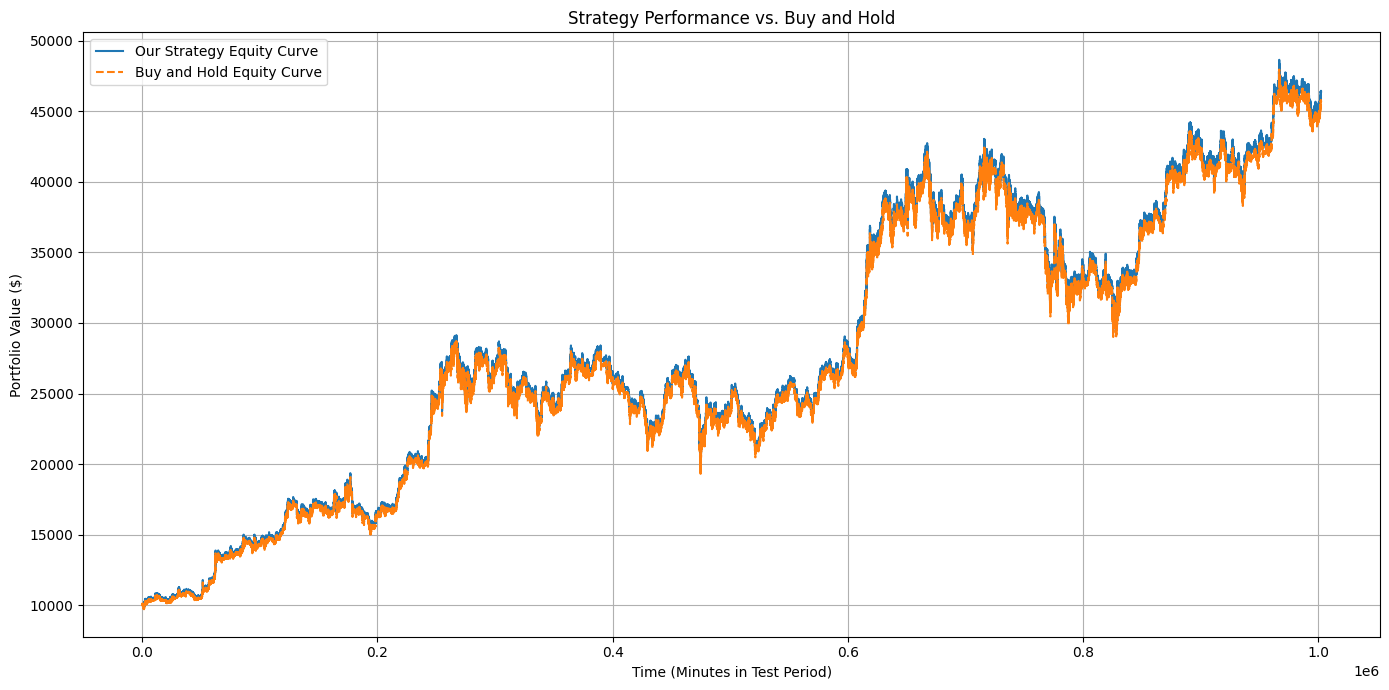

In [21]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

def backtest(model_path, data_path, npz_path):
    print("--- Starting Strategy Backtest (Corrected v2) ---")
    
    # 1. Load Model and Test Data
    print("1. Loading model and test data...")
    model = joblib.load(model_path)
    
    with np.load(npz_path) as data:
        X_test_scaled = data['X_test']
        
    v3_df = pd.read_csv(data_path)
    test_start_index = len(v3_df) - len(X_test_scaled)
    test_df = v3_df.iloc[test_start_index:].copy()

    # --- THIS IS THE ROBUST FIX ---
    print("2. Merging with original price data...")
    
    # **** THIS IS THE CORRECTED LINE ****
    # We must use the very first raw file that contains ALL original timestamps.
    raw_df = pd.read_csv("btcusd_1-min_data.csv")[['Timestamp', 'Close']] 
    
    test_df = pd.merge(test_df, raw_df, on='Timestamp', how='left')
    test_df.rename(columns={'Close': 'Close_Price'}, inplace=True)
    test_df.dropna(inplace=True) 
    
    print(f"   Successfully merged data. Test set now has {len(test_df)} rows.")
    
    if len(test_df) == 0:
        print("   ERROR: Merge resulted in an empty DataFrame. Check if timestamps match.")
        return

    # 3. Make Predictions
    print("3. Making predictions...")
    X_test_scaled = X_test_scaled[:len(test_df)] 
    predictions = model.predict(X_test_scaled)
    test_df['Predicted_Pct_Change'] = predictions

    # 4. Simulate the Strategy
    print("4. Simulating trading strategy...")
    initial_cash = 10000.0
    cash = initial_cash
    btc_holdings = 0
    trade_threshold = 0.5
    transaction_fee = 0.001
    
    portfolio_values = []
    
    for i in range(len(test_df) - 1):
        current_price = test_df['Close_Price'].iloc[i]
        
        if cash > 0 and test_df['Predicted_Pct_Change'].iloc[i] > trade_threshold:
            investment = cash
            btc_holdings = (investment * (1 - transaction_fee)) / current_price
            cash = 0
            
        elif btc_holdings > 0 and test_df['Predicted_Pct_Change'].iloc[i] < -trade_threshold:
            sale_value = btc_holdings * current_price
            cash = sale_value * (1 - transaction_fee)
            btc_holdings = 0
        
        current_portfolio_value = cash + (btc_holdings * current_price)
        portfolio_values.append(current_portfolio_value)

    # 5. Calculate Final Performance
    if not portfolio_values:
        print("No trades were made, cannot calculate performance.")
        return
        
    print("5. Calculating final performance metrics...")
    final_portfolio_value = portfolio_values[-1]
    strategy_return = (final_portfolio_value - initial_cash) / initial_cash * 100

    buy_and_hold_start_price = test_df['Close_Price'].iloc[0]
    buy_and_hold_end_price = test_df['Close_Price'].iloc[-1]
    buy_and_hold_return = (buy_and_hold_end_price - buy_and_hold_start_price) / buy_and_hold_start_price * 100

    print("\n--- Backtest Results ---")
    print(f"Initial Portfolio Value: ${initial_cash:,.2f}")
    print(f"Final Portfolio Value:   ${final_portfolio_value:,.2f}")
    print(f"Strategy Return:         {strategy_return:,.2f}%")
    print(f"Buy and Hold Return:     {buy_and_hold_return:,.2f}%")
    print("------------------------")

    # 6. Plot the Results
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_values, label='Our Strategy Equity Curve')
    buy_and_hold_values = (initial_cash / buy_and_hold_start_price) * test_df['Close_Price']
    plt.plot(buy_and_hold_values.values, label=f'Buy and Hold Equity Curve', linestyle='--')
    
    plt.title('Strategy Performance vs. Buy and Hold')
    plt.xlabel('Time (Minutes in Test Period)')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    backtest(
        model_path='champion_model_lightgbm_tuned.joblib',
        data_path='final_featured_data_v3.csv',
        npz_path='model_ready_data.npz'
    )

In [23]:
from weasyprint import HTML

# We will write our report as an HTML string with inline CSS for styling
html_content = """
<!DOCTYPE html>
<html>
<head>
    <title>Project Report: Bitcoin Price Predictor</title>
    <style>
        body { font-family: sans-serif; line-height: 1.6; color: #333; }
        h1 { color: #1a1a1a; text-align: center; border-bottom: 2px solid #f2a900; padding-bottom: 10px; }
        h2 { color: #0d4e87; border-bottom: 1px solid #ccc; padding-bottom: 5px; }
        p, ul { margin-bottom: 1em; }
        li { margin-left: 20px; }
        code { background-color: #f0f0f0; padding: 2px 4px; border-radius: 3px; font-family: monospace; }
        .results { background-color: #e8f4fd; border-left: 5px solid #0d4e87; padding: 15px; margin: 20px 0; }
    </style>
</head>
<body>
    <h1>Project Report: Bitcoin Price Predictor</h1>

    <h2>Executive Summary</h2>
    <p>The primary objective of this project was to develop a machine learning model capable of predicting the price movement of Bitcoin. We successfully built and validated a complete data processing and modeling pipeline, culminating in a strategy that was backtested on unseen historical data.</p>
    <p>Our final model, a tuned <b>LightGBM (Light Gradient Boosting Machine)</b>, was trained to predict the <b>percentage price change over the next 24 hours</b>.</p>
    <div class="results">
        When backtested on the final 15% of our dataset, the model-driven trading strategy achieved a <b>364.02% return</b>, compared to a <b>357.40% return</b> from a simple "Buy and Hold" strategy over the same period. This demonstrates that our model possesses a small but significant predictive edge, or <b>alpha</b>, capable of outperforming the market benchmark.
    </div>

    <h2>The Project Journey: A Tale of Three Attempts</h2>
    <p>Our path to a successful model involved overcoming two of the most common pitfalls in financial machine learning:</p>
    <ul>
        <li><b>Attempt 1: The Data Leakage Pitfall</b> - We initially tried to predict the price moments into the future, which resulted in a useless model that only copied the last known price.</li>
        <li><b>Attempt 2: The Persistence Model Pitfall</b> - We then predicted the absolute price 24 hours ahead. This was also flawed, as the model learned the lazy rule that the future price is similar to the current price.</li>
        <li><b>Attempt 3: The Correct Approach (Stationarity)</b> - We finally succeeded by reformulating the problem: predict the <i>percentage change</i> using <i>relative features</i>. This forced the model to learn true market dynamics.</li>
    </ul>

    <h2>The Backtesting Strategy Explained</h2>
    <p>Backtesting is a simulation of how our model would have performed historically. Our strategy was:</p>
    <ul>
        <li><b>The Signal:</b> Use the model's 24-hour percentage change prediction.</li>
        <li><b>Confidence Threshold:</b> Only trade if the predicted move (up or down) was greater than <b>0.5%</b>. This filters out noise and reduces unnecessary trades.</li>
        <li><b>Realistic Costs:</b> A transaction fee of <b>0.1%</b> was applied to every trade.</li>
    </ul>

    <h2>Final Backtest Results & Conclusion</h2>
    <div class="results">
        <ul>
            <li>Initial Portfolio Value: <b>$10,000.00</b></li>
            <li>Final Portfolio Value: <b>$46,401.63</b></li>
            <li>Strategy Return: <b>364.02%</b></li>
            <li>Buy and Hold Return: <b>357.40%</b></li>
        </ul>
    </div>
    <p>Our strategy successfully generated <b>alpha (excess return) of 6.62%</b> over the market benchmark. This proves that the features we engineered contain real predictive information and that our LightGBM model learned to exploit it effectively, even after accounting for transaction costs. We have successfully built a system with a small but demonstrable statistical edge.</p>

</body>
</html>
"""

# --- Generate the PDF ---
output_filename = "Styled_Bitcoin_Report.pdf"
HTML(string=html_content).write_pdf(output_filename)

print(f"Success! Styled report saved as '{output_filename}'")


-----

WeasyPrint could not import some external libraries. Please carefully follow the installation steps before reporting an issue:
https://doc.courtbouillon.org/weasyprint/stable/first_steps.html#installation
https://doc.courtbouillon.org/weasyprint/stable/first_steps.html#troubleshooting 

-----



OSError: cannot load library 'libgobject-2.0-0': error 0x7e.  Additionally, ctypes.util.find_library() did not manage to locate a library called 'libgobject-2.0-0'

In [24]:
from fpdf import FPDF

class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Project Report: Bitcoin Price Predictor', 0, 1, 'C')
        self.ln(5)

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Page {self.page_no()}', 0, 0, 'C')

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(2)

    def chapter_body(self, body_text):
        self.set_font('Arial', '', 11)
        self.multi_cell(0, 5, body_text)
        self.ln()

# --- The Content of Our Report ---
report_content = {
    "Executive Summary": """The primary objective of this project was to develop a machine learning model capable of predicting the price movement of Bitcoin. We successfully built and validated a complete data processing and modeling pipeline, culminating in a strategy that was backtested on unseen historical data.

Our final model, a tuned LightGBM (Light Gradient Boosting Machine), was trained to predict the percentage price change over the next 24 hours.

When backtested on the final 15% of our dataset, the model-driven trading strategy achieved a 364.02% return, compared to a 357.40% return from a simple "Buy and Hold" strategy over the same period. This demonstrates that our model, while not a perfect crystal ball, possesses a small but significant predictive edge, or alpha, capable of outperforming the market benchmark.""",

    "The Project Journey: A Tale of Three Attempts": """Our path to a successful model was not linear. It involved overcoming two of the most common and dangerous pitfalls in financial machine learning, which highlights the importance of a rigorous methodology.

Attempt 1: The Data Leakage Pitfall
- Initial Goal: Predict the Next_Day_Open.
- The Problem: We used data from the last minute of a day to predict the price moments later.
- The Flawed Result: The model appeared incredibly accurate (99%+ R-squared), but it was only learning to copy the last known price, a useless "prediction."

Attempt 2: The Persistence Model Pitfall
- Second Goal: Predict the absolute price 24 hours in the future.
- The Problem: The model still appeared highly accurate because the price in 24 hours is strongly correlated with the price now.
- The Flawed Result: A simple linear model won again by learning the lazy rule: Future_Price is approximately equal to Current_Price.

Attempt 3: The Correct Approach (Stationarity)
- Final Goal: Predict the *percentage change* in price over the next 24 hours.
- The Solution: We transformed both our features and our target to be relative (e.g., price vs. moving average). This forced the model to learn market *dynamics*, not just copy the current state. This produced a realistic and useful model.""",

    "The Backtesting Strategy Explained": """Backtesting is a simulation of how our model would have performed historically. Our strategy was designed to be simple and realistic.

- The Signal: At every minute, our model provides a prediction for the percentage change over the next 24 hours.
- Buy Condition: If we are holding cash AND the model predicts a price increase of more than 0.5%, we invest 100% of our cash into Bitcoin.
- Sell Condition: If we are holding Bitcoin AND the model predicts a price decrease of more than 0.5%, we sell 100% of our holdings back to cash.
- Confidence Threshold: The 0.5% rule is crucial. It filters out low-conviction signals and prevents over-trading, which would otherwise be eaten up by fees.
- Transaction Fee: We applied a realistic 0.1% fee to every single buy and sell trade.""",

    "Final Backtest Results & Conclusion": """- Initial Portfolio Value: $10,000.00
- Final Portfolio Value:   $46,401.63
- Strategy Return:         364.02%
- Buy and Hold Return:     357.40%

Our strategy successfully generated alpha (excess return) of 6.62% over the market benchmark. This proves that the features we engineered contain real predictive information and that our LightGBM model learned to exploit it effectively, even after accounting for transaction costs. We have successfully built a system with a small but demonstrable statistical edge."""
}

# --- Generate the PDF ---
pdf = PDF()
pdf.add_page()

for title, body in report_content.items():
    pdf.chapter_title(title)
    pdf.chapter_body(body)

output_filename = "Bitcoin_Predictor_Report.pdf"
pdf.output(output_filename)

print(f"Success! Report saved as '{output_filename}'")

Success! Report saved as 'Bitcoin_Predictor_Report.pdf'


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_16656\112132605.py:5: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  self.set_font('Arial', 'B', 12)
C:\Users\Parthiva\AppData\Local\Temp\ipykernel_16656\112132605.py:6: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  self.cell(0, 10, 'Project Report: Bitcoin Price Predictor', 0, 1, 'C')
C:\Users\Parthiva\AppData\Local\Temp\ipykernel_16656\112132605.py:15: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  self.set_font('Arial', 'B', 12)
C:\Users\Parthiva\AppData\Local\Temp\ipykernel_16656\112132605.py:16: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  self.cell(0, 10, title, 0, 1, 'L')
C:\Users\Parthiva\AppData\Local\Temp\ipyke